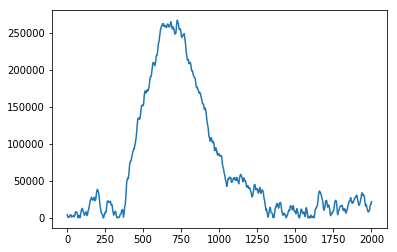

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import QPP_Funcs as qpp
import celerite as ce
import corner


log_params = [22.72641517, -1.67366546, -2.87090837, 14.90899254, 8.23744964, 4.8174639]

N = 1000
t = np.linspace(1,2001, N)
truemodel = qpp.CTSModel_prior(log_A = log_params[3], log_tau1 = log_params[4], log_tau2 = log_params[5])
truekernel = qpp.SHOTerm_Prior(log_S0 = log_params[0], log_Q = log_params[1], log_omega0 = log_params[2])
I = qpp.simulate(t, truemodel, truekernel, noisy=True)
plt.plot(t,I)
plt.show()


In [6]:
A_guess, t1_guess, t2_guess = qpp.initguess(t,I)
Ierr=np.sqrt(I)
model = qpp.CTSModel_prior(log_A = np.log(A_guess), log_tau1 = np.log(t1_guess), log_tau2 = np.log(t2_guess))
kernel = qpp.SHOTerm_Prior(log_S0 = np.log(1e8), log_Q = np.log(1e2), log_omega0 = np.log(0.07)) #write guesser for kernel parameters
gp = ce.GP(kernel, mean=model, fit_mean=True)
gp.compute(t, Ierr)

In [8]:
soln = qpp.optimize_gp(gp, I)

Initial log-likelihood: -8698.43770176
Final log-likelihood: -8698.43769867
Optimized log-parameters: [ 29.55802113  -3.01613539  -4.21567736  12.38560281   6.88217903
   7.09293127]


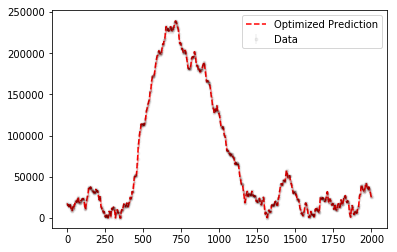

In [9]:
fig = qpp.plot_gp(t, I, Ierr, gp, model, soln=soln)
plt.show()

In [10]:
sampler = qpp.sample_gp(soln.x, I, gp, nsteps = 1500)

Burning in...


QPP_Funcs.py:55: RuntimeWarning: divide by zero encountered in log
  return np.log(prob_S0*prob_Q*prob_omega0 * np.e)
QPP_Funcs.py:39: RuntimeWarning: divide by zero encountered in log
  return np.log(probA * probtau1 * probtau2 * np.e)
QPP_Funcs.py:16: RuntimeWarning: overflow encountered in exp
  lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
QPP_Funcs.py:17: RuntimeWarning: invalid value encountered in multiply
  return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))


Sampling...


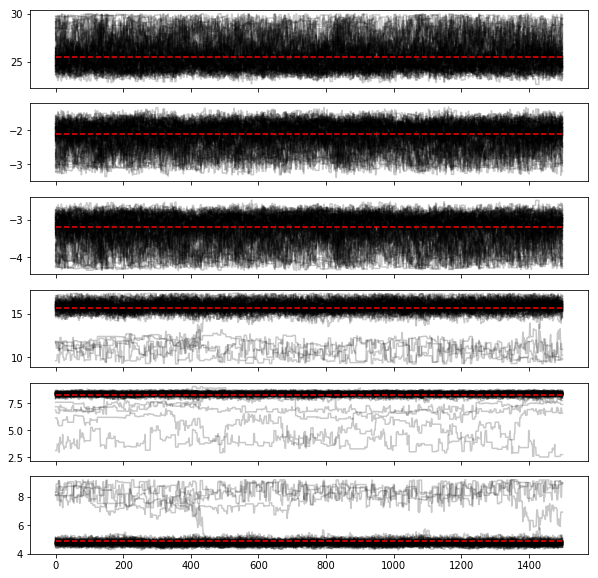

In [11]:
chain = sampler.chain
fig = qpp.plot_chain(chain)
plt.show()

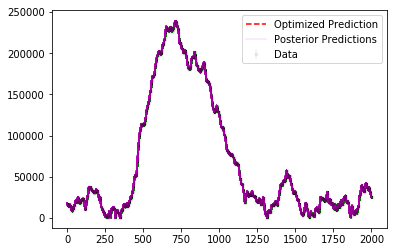

In [12]:
fig = qpp.plot_gp(t, I, Ierr, gp, model, soln=soln, chain=chain)
plt.show()

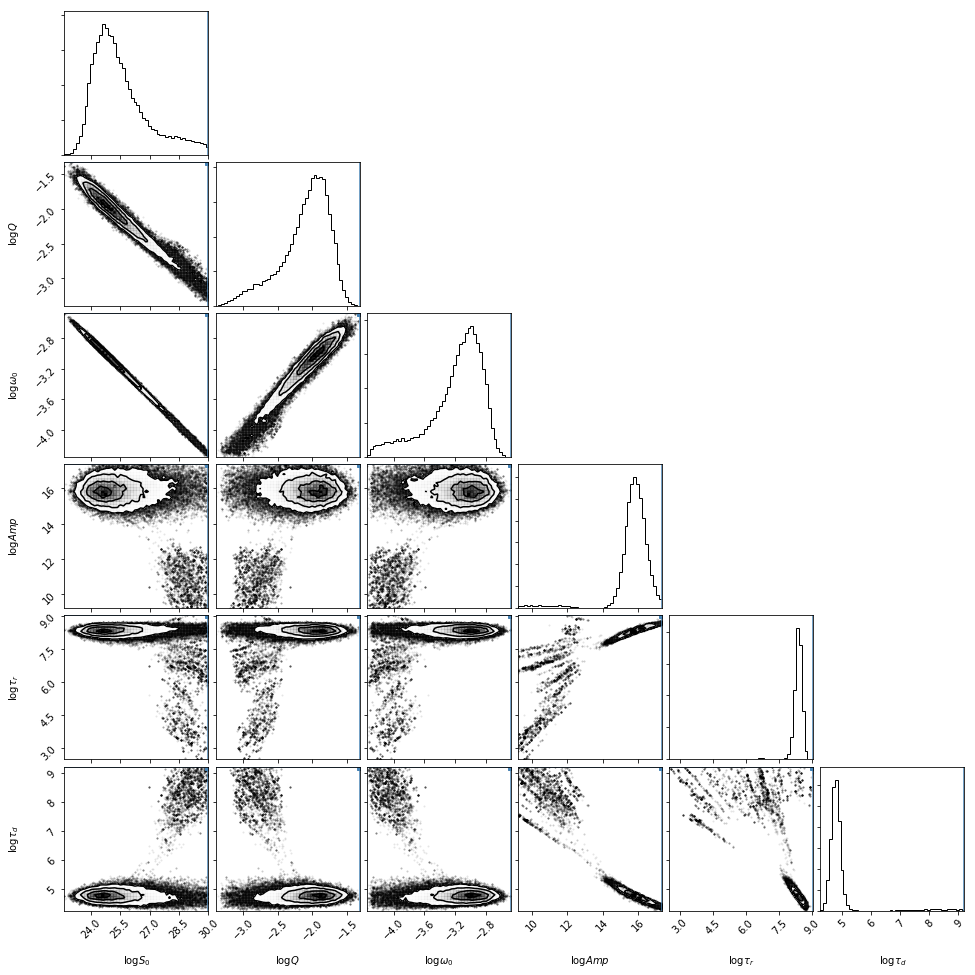

In [16]:
flat_samples = chain[:,200:, :].reshape((-1,6))
maxparams = np.amax(flat_samples, axis=0)
fig = corner.corner(flat_samples, bins=50, labels = [r"$\log{S_0}$", r"$\log{Q}$", r"$\log{\omega_0}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = maxparams,  range = [1,1,1,1,1,1])
plt.show()

In [18]:
print maxparams
print np.exp(maxparams)
print log_params
print np.exp(log_params)

[ 29.998758    -1.31968948  -2.4736889   17.36970138   9.04124252
   9.2078944 ]
[  1.06732103e+13   2.67218266e-01   8.42734089e-02   3.49595199e+07
   8.44426271e+03   9.97557019e+03]
[22.72641517, -1.67366546, -2.87090837, 14.90899254, 8.23744964, 4.8174639]
[  7.41236338e+09   1.87558317e-01   5.66474464e-02   2.98464849e+06
   3.77988793e+03   1.23651101e+02]
